In [1]:
import tensorflow as tf
tf.__version__

'1.0.1'

In [2]:
import sys
sys.version

'3.4.5 (default, Nov  9 2016, 16:24:59) \n[GCC 4.8.5 20150623 (Red Hat 4.8.5-11)]'

0 0.000218084
保存模型： stock2.model-0
1 0.000242481
2 0.000293276
3 0.000221399
4 0.000354613
5 0.000211796
6 0.000287291
7 0.000211521
8 0.000259778
9 0.000249916
10 0.000225575
11 0.00035011
12 0.000218625
13 0.000310391
14 0.000205763
15 0.000304543
16 0.000213991
17 0.000248215
18 0.000270262
19 0.000222374
20 0.00034095
21 0.000210408
22 0.000281531
23 0.000209635
24 0.000261166
25 0.000236748
26 0.000229641
27 0.000320338
28 0.000216672
29 0.000311725
30 0.000205615
31 0.000288189
32 0.000214564
33 0.000248752
34 0.000264953
35 0.000221604
36 0.000339905
37 0.00021042
38 0.00028469
39 0.000207749
40 0.000263052
41 0.000234294
42 0.000229964
43 0.000319243
44 0.000215124
45 0.000304409
46 0.000203301
47 0.000291576
48 0.000212539
49 0.000250824
50 0.000251507
51 0.000220858
52 0.000323102
53 0.000206141
54 0.000282057
55 0.000206936
56 0.000263178
57 0.000226999
58 0.000235894
59 0.000293924
60 0.000213895
61 0.000309744
62 0.000204075
63 0.000281281
64 0.000211268
65 0.000254327
66 

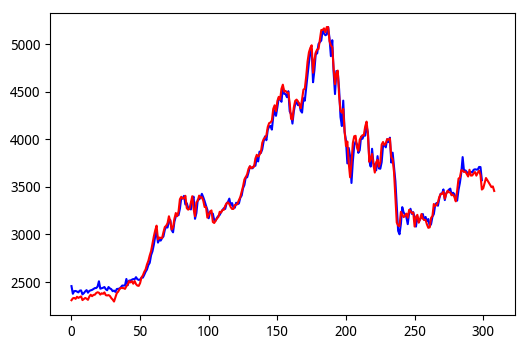

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# coding=utf-8
# coding: utf-8

import os
cwd=os.getcwd()
cwd_name=cwd+'/whatever'
save_path = "model_p/model.ckpt"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#定义常量

rnn_unit=10       #hidden layer units

input_size=7
output_size=1
lr=0.0006         #学习率
#——————————————————导入数据——————————————————————
f=open('dataset_2.csv')  

# with open('dataset_2.csv')  as f: 
    # df=pd.read_csv(f) 



df=pd.read_csv(f)     #读入股票数据

## get all data in dataframe from 'dataset_2.csv'

## get data for train and prediction
data=df.iloc[:,2:10].values  #取第3-10列 

 

#获取训练集
def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=5800):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集 
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:7]
        y=normalized_train_data[i:i+time_step,7,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

#获取测试集

def get_test_data(time_step=20,test_begin=5800):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size = (len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
    test_x,test_y=[],[]  
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,:7]
        y=normalized_test_data[i*time_step:(i+1)*time_step,7]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:7]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,7]).tolist())
    return mean,std,test_x,test_y

#——————————————————定义神经网络变量——————————————————
#输入层、输出层权重、偏置

weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

#——————————————————定义神经网络变量——————————————————
def lstm(X):     
    
  
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in) + b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    #???
            # tf.nn.rnn_cell.LSTMCell
            # cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
            # tf.contrib.rnn

    cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
        #tf.contrib.rnn.BasicLSTMCell(rnn_unit)
        

#             cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
#             cell=tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_unit)
#        
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

#——————————————————训练模型——————————————————
variable_control=0
def train_lstm(batch_size=80,time_step=15,train_begin=2000,train_end=5800):
    global variable_control
    
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    with tf.variable_scope('prediction'):
        pred,_=lstm(X)
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
    
    module_file = tf.train.latest_checkpoint('./')    
    
    with tf.Session() as sess:
#         if variable_control==0:
        sess.run(tf.global_variables_initializer())
        try:
            saver.restore(sess, module_file)
        except :
            pass
        
        #重复训练10000次
        for i in range(2000):
            for step in range(len(batch_index)-1):
                _ , loss_ = sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            print(i,loss_)
            if i % 500==0:
#                 save_path = saver.save(sess, "model.ckpt")
#                 print(i,loss_)
                print("保存模型：",saver.save(sess,'stock2.model',global_step=i))
#     variable_control+=1
                
train_lstm()





#————————————————预测模型————————————————————
def prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    #Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope('prediction',reuse=True):
        pred,_=lstm(X)
#     with lstm:
#         pred,_lstm=lstm_func(X)

#     pred,_=lstm(X)     
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint('./')
        with tf.variable_scope('prediction',reuse=True):
            saver.restore(sess, module_file) 
            #saver.restore(sess, tf.train.latest_checkpoint('./') )
        test_predict=[]
        for step in range(len(test_x)-1):
            
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        global acc
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差
        #以折线图表示结果
#         print(acc)
        global real_price
        global predict_price
        real_price=test_y[:len(test_predict)]
        predict_price=test_predict
        
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b')
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()

prediction() 






In [4]:
acc

0.01486971469303971

In [6]:
predict_price

array([ 2455.93945312,  2375.44775391,  2402.82910156,  2404.93139648,
        2398.82373047,  2390.03271484,  2408.23583984,  2410.53881836,
        2369.0065918 ,  2381.62695312,  2400.30126953,  2413.97705078,
        2386.67578125,  2405.20678711,  2411.34716797,  2416.14746094,
        2424.93652344,  2434.66845703,  2435.73022461,  2450.12060547,
        2506.66845703,  2428.77001953,  2434.06152344,  2438.54980469,
        2446.27148438,  2423.14257812,  2412.37792969,  2446.1328125 ,
        2431.31445312,  2423.52392578,  2402.66064453,  2408.79736328,
        2395.30444336,  2424.99169922,  2427.9296875 ,  2429.70581055,
        2444.22216797,  2461.79980469,  2460.9609375 ,  2463.08154297,
        2531.02905273,  2465.12011719,  2513.70288086,  2514.75927734,
        2523.21020508,  2530.0300293 ,  2527.57202148,  2549.54833984,
        2528.51660156,  2520.67358398,  2525.2434082 ,  2544.48266602,
        2545.39257812,  2573.60864258,  2606.43408203,  2630.11376953,
      

In [5]:
real_price

array([ 2307.7 ,  2327.56,  2331.92,  2321.91,  2343.6 ,  2331.95,
        2340.45,  2347.94,  2309.05,  2319.88,  2331.56,  2323.55,
        2311.53,  2345.75,  2365.15,  2350.11,  2363.06,  2365.49,
        2382.79,  2391.35,  2386.28,  2366.86,  2380.52,  2374.81,
        2389.68,  2360.6 ,  2357.51,  2361.65,  2352.12,  2329.93,
        2314.88,  2293.64,  2338.28,  2381.64,  2397.26,  2423.6 ,
        2436.79,  2435.22,  2434.36,  2426.89,  2454.42,  2474.16,
        2508.62,  2494.92,  2507.74,  2481.03,  2508.77,  2477.05,
        2461.49,  2458.32,  2488.2 ,  2546.75,  2568.38,  2605.07,
        2631.4 ,  2683.18,  2720.74,  2777.37,  2824.18,  2900.51,
        2978.03,  3041.66,  3091.32,  2946.71,  2965.68,  2962.51,
        2960.23,  3021.9 ,  3076.6 ,  3089.79,  3117.53,  3189.87,
        3136.84,  3050.51,  3073.35,  3164.16,  3223.86,  3190.3 ,
        3239.36,  3369.28,  3394.22,  3374.9 ,  3381.57,  3404.83,
        3275.19,  3259.39,  3268.48,  3337.08,  3400.32,  3262

In [9]:
# contr=pd.DataFrame({'real':real_price,'predict':predict_price})

# contr.to_excel('real_and_predict.xls')